In [ ]:
from huggingface_hub import login
from google.colab import userdata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
import warnings
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
hf_token = userdata.get('huggingface')
login(hf_token)

In [ ]:
dataset_dim1 = load_dataset('Zlovoblachko/DeepSeek_dim1')

README.md:   0%|          | 0.00/684 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1080 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

In [ ]:
train_df = pd.DataFrame(dataset_dim1['train'])
dev_df = pd.DataFrame(dataset_dim1['dev'])
test_df = pd.DataFrame(dataset_dim1['test'])

In [ ]:
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {dev_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nClass distribution in train:\n{train_df['Dim1_label'].value_counts()}")

Train shape: (1080, 6)
Validation shape: (135, 6)
Test shape: (135, 6)

Class distribution in train:
Dim1_label
L    540
H    540
Name: count, dtype: int64


In [ ]:
def combine_text_columns(df):
    text_columns = ['Thesis', 'Target sentence segment', 'Last argument', 'Target sentence']
    combined = df[text_columns].fillna('').agg(' '.join, axis=1)
    return combined

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
X_train_text = combine_text_columns(train_df)
y_train = train_df['Dim1_label']
X_val_text = combine_text_columns(dev_df)
y_val = dev_df['Dim1_label']
X_test_text = combine_text_columns(test_df)
y_test = test_df['Dim1_label']

print(f"Sample combined text:\n{X_train_text.iloc[0][:200]}...")

Sample combined text:
 in my opinion it is uself and fun to do pysical exercise and my activity every day. I disagre wits his opinion because these people do not understand that sport should keep fit and mind. Introductory...


In [ ]:
count_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.95)

In [ ]:
X_train_count = count_vectorizer.fit_transform(X_train_text)
X_val_count = count_vectorizer.transform(X_val_text)
X_test_count = count_vectorizer.transform(X_test_text)

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [ ]:
print(f"CountVectorizer shape: {X_train_count.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

CountVectorizer shape: (1080, 1542)
TF-IDF shape: (1080, 1542)


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

vectorizers = {
    'CountVectorizer': (X_train_count, X_val_count, X_test_count),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf)
}

In [ ]:
results = {}

for vec_name, (X_tr, X_v, X_te) in vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Vectorizer: {vec_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,  # 5-fold cross-validation
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )
        # Fit on training data
        grid_search.fit(X_tr, y_train_encoded)
        # Best model from grid search
        best_model = grid_search.best_estimator_
        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_train_encoded,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{vec_name}_{model_name}"
        results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Vectorizer: CountVectorizer

Training Logistic Regression...
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8245 (+/- 0.0219)
CV Accuracy: 0.8250 (+/- 0.0218)

Training Decision Tree...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV F1 Score: 0.7573 (+/- 0.0126)
CV Accuracy: 0.7574 (+/- 0.0126)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
CV F1 Score: 0.8434 (+/- 0.0253)
CV Accuracy: 0.8435 (+/- 0.0253)

Vectorizer: TF-IDF

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8275 (+/- 0.0255)
CV Accuracy: 0.8278 (+/- 0.0254)

Training Decision Tree...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV F1 Score: 0.7290 (+/- 0.0227)
CV Accuracy: 0.7296 (+/- 0.0224)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators

In [ ]:
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Predict on validation set
    y_val_pred = res['best_model'].predict(res['X_val'])
    print(classification_report(y_val_encoded, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Predict on test set
    y_test_pred = res['best_model'].predict(res['X_test'])
    print(classification_report(y_test_encoded, y_test_pred, digits=4))


VALIDATION SET PERFORMANCE

CountVectorizer_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8358    0.8358    0.8358        67
           1     0.8382    0.8382    0.8382        68

    accuracy                         0.8370       135
   macro avg     0.8370    0.8370    0.8370       135
weighted avg     0.8370    0.8370    0.8370       135

Cross-Validation Reliability:
  Accuracy: 0.8250 (std: 0.0218)
  F1-Score: 0.8245 (std: 0.0219)

CountVectorizer_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7246    0.7463    0.7353        67
           1     0.7424    0.7206    0.7313        68

    accuracy                         0.7333       135
   macro avg     0.7335    0.7334    0.7333       135
weighted avg     0.7336    0.7333    0.7333       135

Cross-Validation Reliability:
  


CountVectorizer:
------------------------------------------------------------


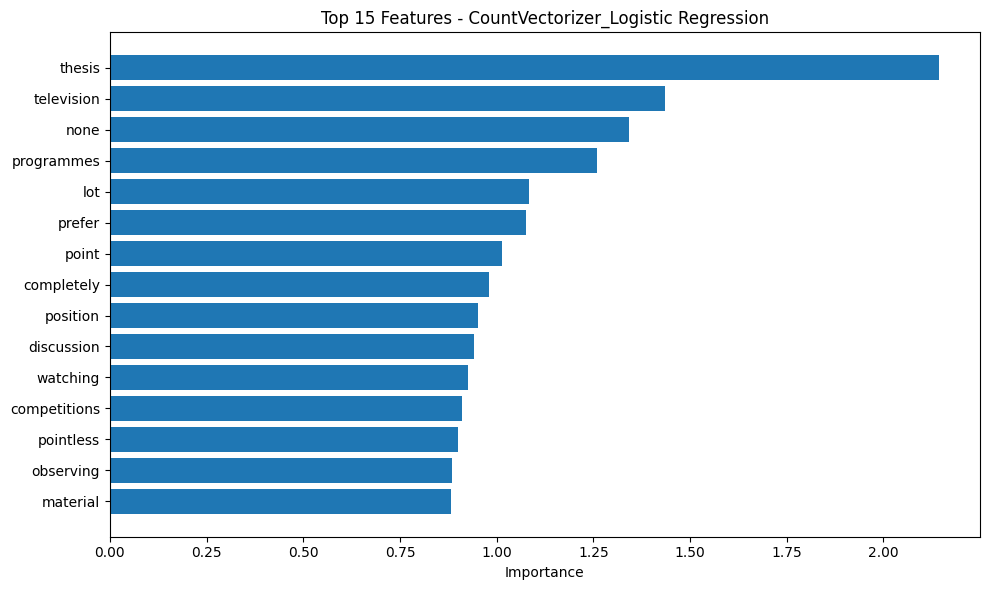


Logistic Regression - Top 10 features:
  discussion: 0.9419
  position: 0.9517
  completely: 0.9801
  point: 1.0136
  prefer: 1.0769
  lot: 1.0848
  programmes: 1.2606
  none: 1.3431
  television: 1.4344
  thesis: 2.1424


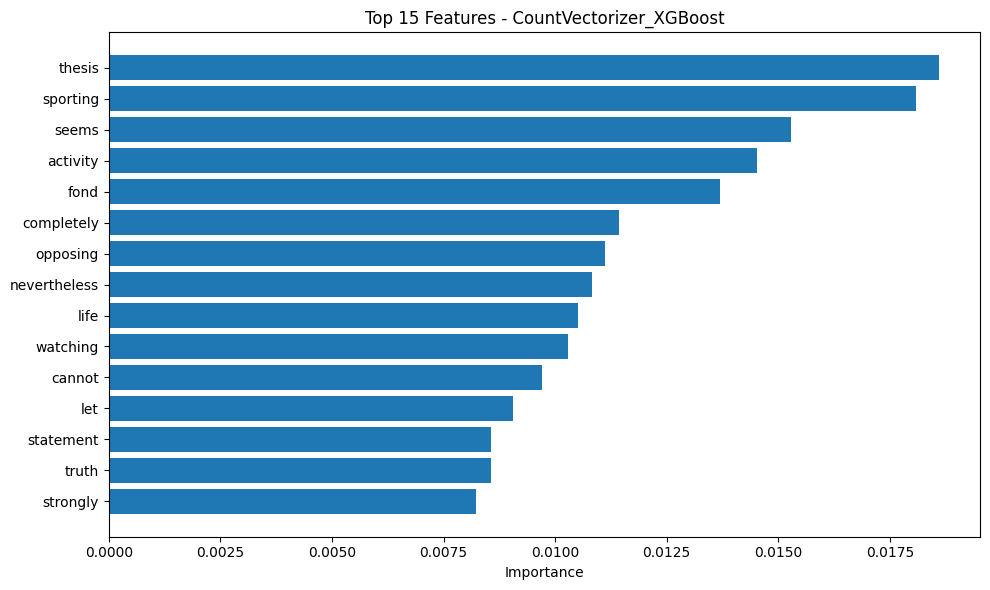


XGBoost - Top 10 features:
  watching: 0.0103
  life: 0.0105
  nevertheless: 0.0108
  opposing: 0.0111
  completely: 0.0114
  fond: 0.0137
  activity: 0.0145
  seems: 0.0153
  sporting: 0.0181
  thesis: 0.0186

TF-IDF:
------------------------------------------------------------


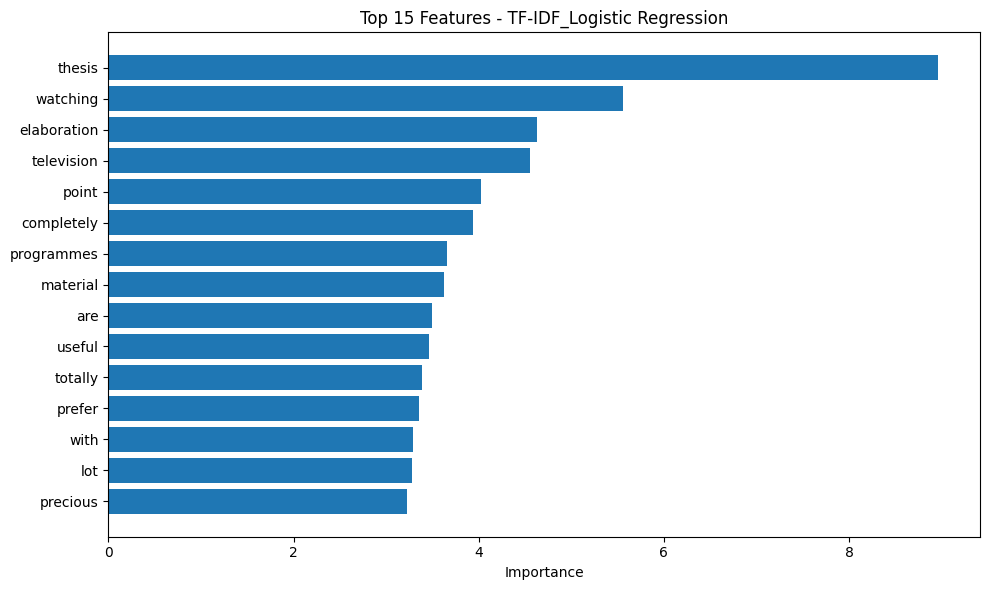


Logistic Regression - Top 10 features:
  useful: 3.4650
  are: 3.4958
  material: 3.6301
  programmes: 3.6555
  completely: 3.9436
  point: 4.0195
  television: 4.5571
  elaboration: 4.6320
  watching: 5.5619
  thesis: 8.9673


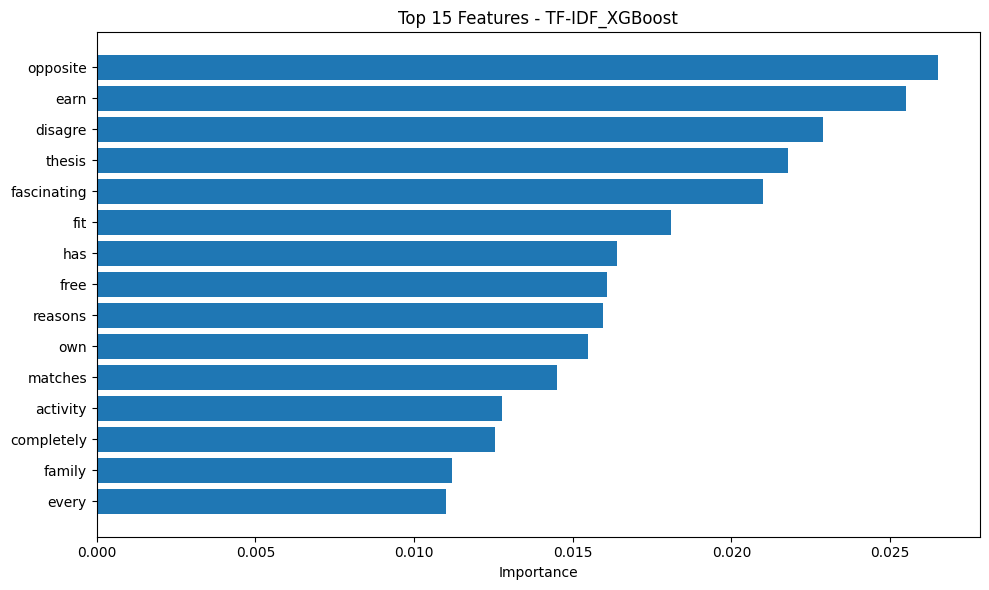


XGBoost - Top 10 features:
  own: 0.0155
  reasons: 0.0160
  free: 0.0161
  has: 0.0164
  fit: 0.0181
  fascinating: 0.0210
  thesis: 0.0218
  disagre: 0.0229
  earn: 0.0255
  opposite: 0.0265


In [ ]:
for vec_name, (X_tr, X_v, X_te) in vectorizers.items():
    vectorizer = count_vectorizer if vec_name == 'CountVectorizer' else tfidf_vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Extract feature importance
        if hasattr(model, 'coef_'):  # Logistic Regression
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):  # Tree-based models
            importance = model.feature_importances_
        else:
            continue

        # Top 15 features
        top_indices = np.argsort(importance)[-15:]
        top_features = feature_names[top_indices]
        top_importance = importance[top_indices]

        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(top_features)), top_importance)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {key}')
        plt.tight_layout()
        plt.show()

        print(f"\n{model_name} - Top 10 features:")
        for feat, imp in zip(top_features[-10:], top_importance[-10:]):
            print(f"  {feat}: {imp:.4f}")

In [ ]:
summary_data = []

for key, res in results.items():
    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_val_encoded, y_val_pred),
        'Val_F1': f1_score(y_val_encoded, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_test_encoded, y_test_pred),
        'Test_F1': f1_score(y_test_encoded, y_test_pred, average='weighted')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY COMPARISON TABLE
                      Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
CountVectorizer_Logistic Regression            0.8250           0.0218      0.8245     0.0219        0.8370  0.8370         0.8148   0.8146
      CountVectorizer_Decision Tree            0.7574           0.0126      0.7573     0.0126        0.7333  0.7333         0.7259   0.7251
            CountVectorizer_XGBoost            0.8435           0.0253      0.8434     0.0253        0.8444  0.8444         0.8296   0.8296
         TF-IDF_Logistic Regression            0.8278           0.0254      0.8275     0.0255        0.8444  0.8444         0.7926   0.7926
               TF-IDF_Decision Tree            0.7296           0.0224      0.7290     0.0227        0.7630  0.7628         0.6963   0.6961
                     TF-IDF_XGBoost            0.8352           0.0260      0.8350     0.0261        0.8444  0.8443         0.8148   0

Add preprocessing

In [ ]:
def preprocess_text(text):
    """Tokenize, lowercase, and lemmatize text using spaCy"""
    if pd.isna(text) or text == '':
        return ''

    # Process text with spaCy
    doc = nlp(text.lower())

    # Lemmatize and keep only alphabetic tokens
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]

    return ' '.join(lemmatized)

In [ ]:
text_columns = ['Thesis', 'Target sentence segment', 'Last argument', 'Target sentence']

print("Preprocessing training data...")
for col in text_columns:
    train_df[col] = train_df[col].apply(preprocess_text)

print("Preprocessing validation data...")
for col in text_columns:
    dev_df[col] = dev_df[col].apply(preprocess_text)

print("Preprocessing test data...")
for col in text_columns:
    test_df[col] = test_df[col].apply(preprocess_text)

print("\nSample preprocessed text:")
print(f"{train_df['Target sentence'].iloc[0][:200]}...")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Sample preprocessed text:
however some people prefer to watch sport show on tv...


In [ ]:
X_train = train_df[text_columns]
X_val = dev_df[text_columns]
X_test = test_df[text_columns]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1080, 4)
X_val shape: (135, 4)
X_test shape: (135, 4)


In [ ]:
count_transformer = ColumnTransformer(
    transformers=[
        ('thesis', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Thesis'),
        ('segment', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target sentence segment'),
        ('argument', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Last argument'),
        ('target', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target sentence')
    ],
    remainder='drop',
    sparse_threshold=1.0
)

In [ ]:
tfidf_transformer = ColumnTransformer(
    transformers=[
        ('thesis', TfidfVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Thesis'),
        ('segment', TfidfVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target sentence segment'),
        ('argument', TfidfVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Last argument'),
        ('target', TfidfVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target sentence')
    ],
    remainder='drop',
    sparse_threshold=1.0
)

In [ ]:
print("Fitting CountVectorizer...")
X_train_count = count_transformer.fit_transform(X_train)
X_val_count = count_transformer.transform(X_val)
X_test_count = count_transformer.transform(X_test)

print("Fitting TF-IDF...")
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_val_tfidf = tfidf_transformer.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test)

print(f"\nCountVectorizer shape: {X_train_count.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

Fitting CountVectorizer...
Fitting TF-IDF...

CountVectorizer shape: (1080, 2207)
TF-IDF shape: (1080, 2207)


In [ ]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

vectorizers = {
    'CountVectorizer': (X_train_count, X_val_count, X_test_count, count_transformer),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_transformer)
}

In [ ]:
results = {}

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Vectorizer: {vec_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")

        # Use encoded labels for XGBoost, original for others
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train

        # GridSearchCV with validation set scoring
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )

        # Fit on training data
        grid_search.fit(X_tr, y_tr)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_tr,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{vec_name}_{model_name}"
        results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te,
            'is_xgboost': model_name == 'XGBoost',
            'transformer': transformer
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Vectorizer: CountVectorizer

Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8489 (+/- 0.0277)
CV Accuracy: 0.8491 (+/- 0.0276)

Training Decision Tree...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV F1 Score: 0.8308 (+/- 0.0313)
CV Accuracy: 0.8315 (+/- 0.0308)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
CV F1 Score: 0.8814 (+/- 0.0185)
CV Accuracy: 0.8815 (+/- 0.0184)

Vectorizer: TF-IDF

Training Logistic Regression...
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8758 (+/- 0.0170)
CV Accuracy: 0.8759 (+/- 0.0169)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV F1 Score: 0.8295 (+/- 0.0323)
CV Accuracy: 0.8306 (+/- 0.0316)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators':

In [ ]:
for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_val_pred = res['best_model'].predict(res['X_val'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        print(classification_report(y_val, y_val_pred_decoded, digits=4))
    else:
        print(classification_report(y_val, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        print(classification_report(y_test, y_test_pred_decoded, digits=4))
    else:
        print(classification_report(y_test, y_test_pred, digits=4))


CountVectorizer_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.8824    0.8955    0.8889        67
           L     0.8955    0.8824    0.8889        68

    accuracy                         0.8889       135
   macro avg     0.8889    0.8889    0.8889       135
weighted avg     0.8890    0.8889    0.8889       135

Cross-Validation Reliability:
  Accuracy: 0.8491 (std: 0.0276)
  F1-Score: 0.8489 (std: 0.0277)

CountVectorizer_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.8056    0.8657    0.8345        67
           L     0.8571    0.7941    0.8244        68

    accuracy                         0.8296       135
   macro avg     0.8313    0.8299    0.8295       135
weighted avg     0.8315    0.8296    0.8294       135

Cross-Validation Reliability:
  Accuracy: 0.8315 (std: 0.030

In [ ]:
from sklearn.metrics import f1_score as f1_metric

print("\n" + "="*80)
print("COLUMN IMPORTANCE ANALYSIS")
print("="*80)
print("\nMeasuring importance by column ablation (removing each column):\n")

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Baseline performance on validation set
        y_v = y_val_encoded if results[key]['is_xgboost'] else y_val
        baseline_pred = model.predict(X_v)
        baseline_f1 = f1_metric(y_v, baseline_pred, average='weighted')

        print(f"\n{model_name}:")
        print(f"  Baseline F1 (all columns): {baseline_f1:.4f}")

        # Test importance by removing each column
        column_importance = {}
        for i, col in enumerate(text_columns):
            # Create data with one column removed (set to empty)
            X_val_ablated = X_val.copy()
            X_val_ablated[col] = ''

            # Transform and predict
            X_v_ablated = transformer.transform(X_val_ablated)
            ablated_pred = model.predict(X_v_ablated)
            ablated_f1 = f1_metric(y_v, ablated_pred, average='weighted')

            # Importance = drop in performance when column removed
            importance = baseline_f1 - ablated_f1
            column_importance[col] = importance

            print(f"  {col}: {importance:.4f} (F1 without: {ablated_f1:.4f})")


COLUMN IMPORTANCE ANALYSIS

Measuring importance by column ablation (removing each column):


CountVectorizer:
------------------------------------------------------------

Logistic Regression:
  Baseline F1 (all columns): 0.8889
  Thesis: 0.4783 (F1 without: 0.4106)
  Target sentence segment: 0.0150 (F1 without: 0.8739)
  Last argument: 0.0297 (F1 without: 0.8592)
  Target sentence: 0.1012 (F1 without: 0.7877)

XGBoost:
  Baseline F1 (all columns): 0.9036
  Thesis: 0.3872 (F1 without: 0.5164)
  Target sentence segment: 0.0000 (F1 without: 0.9036)
  Last argument: 0.0599 (F1 without: 0.8437)
  Target sentence: 0.0685 (F1 without: 0.8351)

TF-IDF:
------------------------------------------------------------

Logistic Regression:
  Baseline F1 (all columns): 0.9037
  Thesis: 0.3634 (F1 without: 0.5403)
  Target sentence segment: 0.0149 (F1 without: 0.8888)
  Last argument: 0.0075 (F1 without: 0.8962)
  Target sentence: 0.0305 (F1 without: 0.8732)

XGBoost:
  Baseline F1 (all columns): 0


COLUMN IMPORTANCE VISUALIZATION


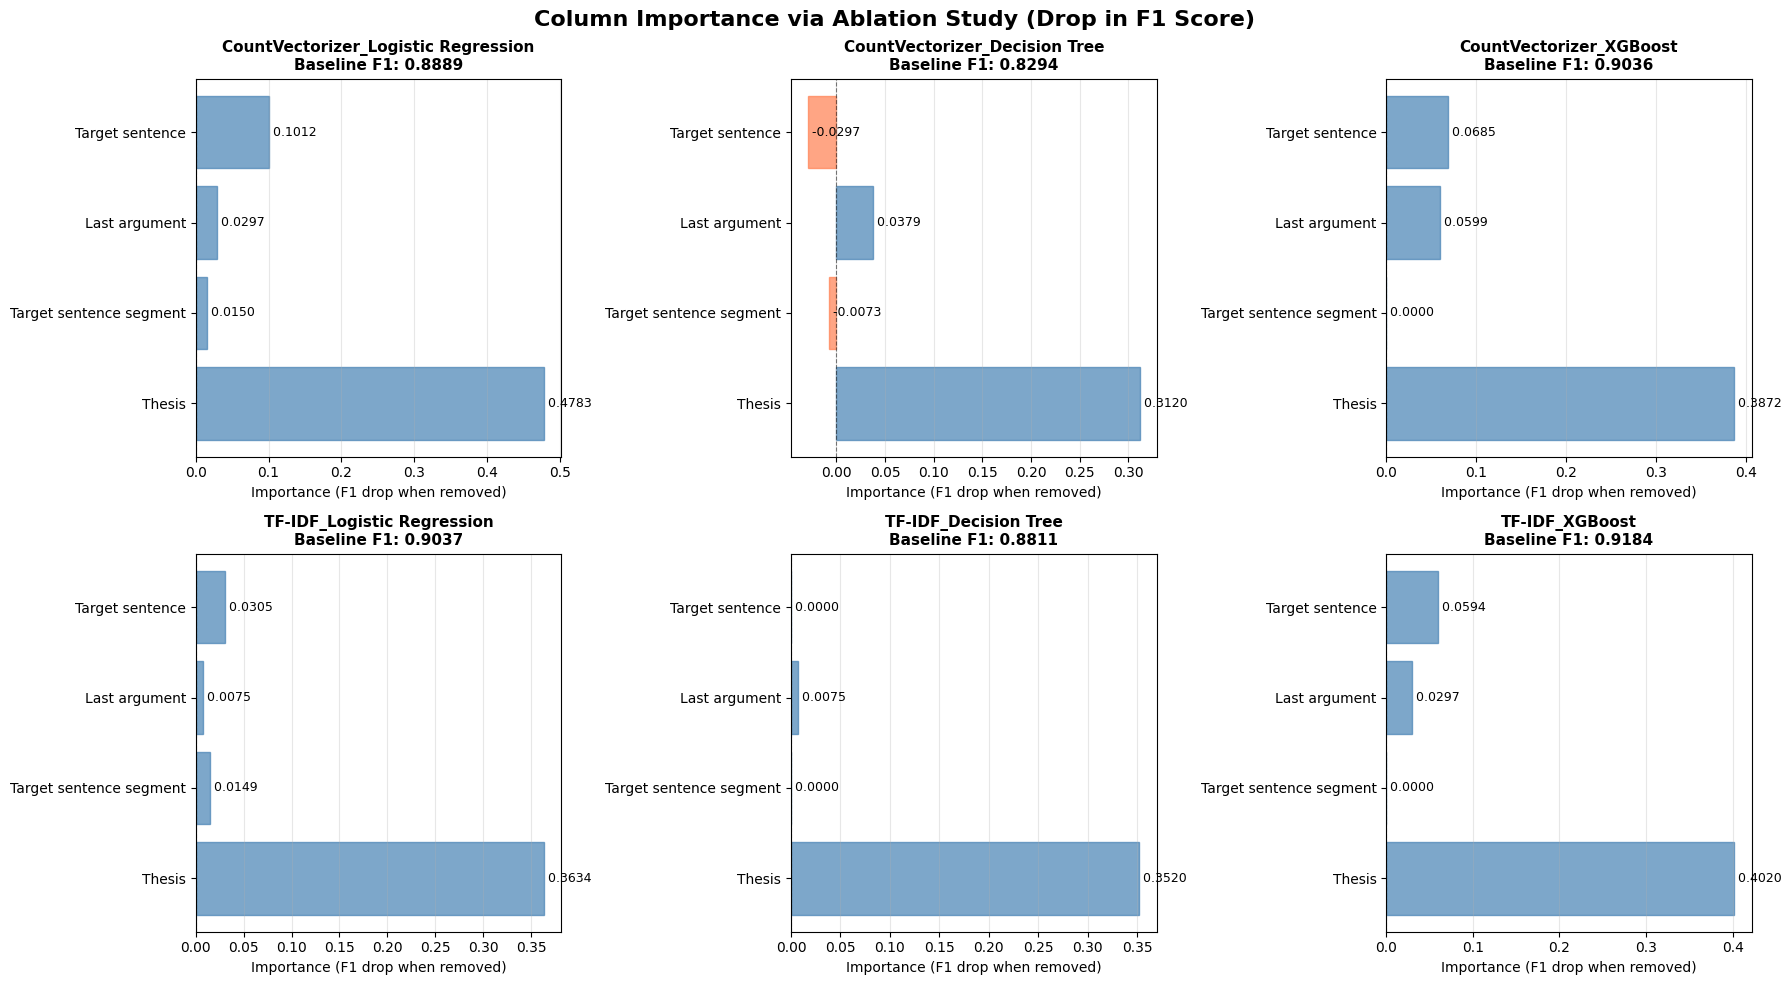


AVERAGE COLUMN IMPORTANCE ACROSS ALL MODELS


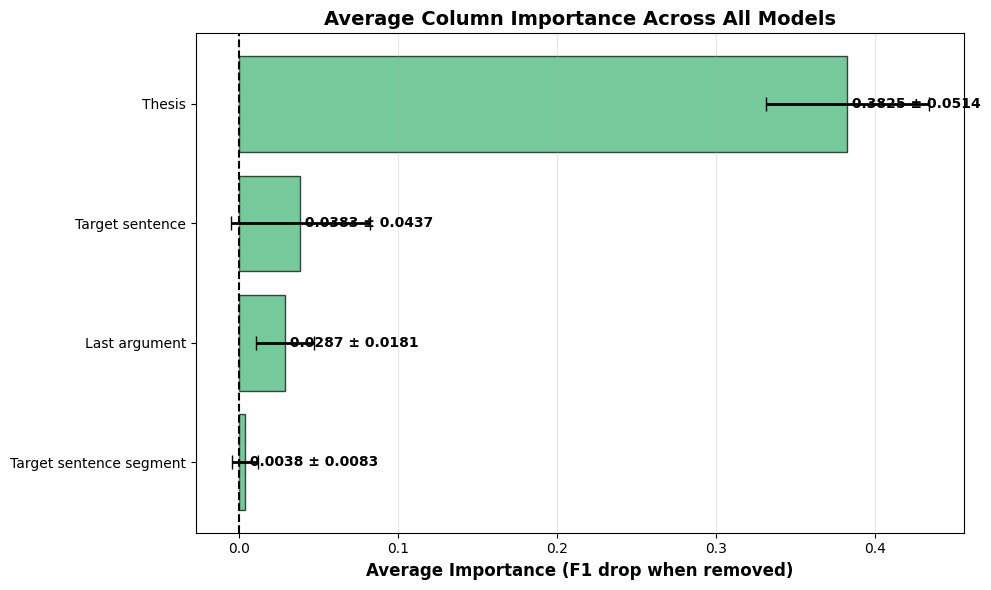


Column Importance Summary:
------------------------------------------------------------
Target sentence segment       :  0.0038 ± 0.0083
Last argument                 :  0.0287 ± 0.0181
Target sentence               :  0.0383 ± 0.0437
Thesis                        :  0.3825 ± 0.0514


In [ ]:
print("\n" + "="*80)
print("COLUMN IMPORTANCE VISUALIZATION")
print("="*80)

# Collect all ablation results
ablation_results = {}

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    for model_name in ['Logistic Regression', 'Decision Tree', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Baseline performance on validation set
        y_v = y_val_encoded if results[key]['is_xgboost'] else y_val
        baseline_pred = model.predict(X_v)
        baseline_f1 = f1_metric(y_v, baseline_pred, average='weighted')

        # Test importance by removing each column
        column_importance = {}
        for col in text_columns:
            # Create data with one column removed
            X_val_ablated = X_val.copy()
            X_val_ablated[col] = ''

            # Transform and predict
            X_v_ablated = transformer.transform(X_val_ablated)
            ablated_pred = model.predict(X_v_ablated)
            ablated_f1 = f1_metric(y_v, ablated_pred, average='weighted')

            # Importance = drop in performance when column removed
            importance = baseline_f1 - ablated_f1
            column_importance[col] = importance

        ablation_results[key] = {
            'baseline': baseline_f1,
            'importance': column_importance
        }

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Column Importance via Ablation Study (Drop in F1 Score)', fontsize=16, fontweight='bold')

plot_idx = 0
for vec_name in ['CountVectorizer', 'TF-IDF']:
    for model_name in ['Logistic Regression', 'Decision Tree', 'XGBoost']:
        key = f"{vec_name}_{model_name}"

        ax = axes[plot_idx // 3, plot_idx % 3]

        importance_dict = ablation_results[key]['importance']
        columns = list(importance_dict.keys())
        importance_values = list(importance_dict.values())

        # Create bar plot
        bars = ax.barh(columns, importance_values, color='steelblue', alpha=0.7, edgecolor='black')

        # Color bars: positive (important) in blue, negative (harmful) in red
        for bar, val in zip(bars, importance_values):
            if val < 0:
                bar.set_color('coral')
            else:
                bar.set_color('steelblue')

        # Add value labels
        for i, (col, val) in enumerate(zip(columns, importance_values)):
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=9)

        # Formatting
        ax.set_xlabel('Importance (F1 drop when removed)', fontsize=10)
        ax.set_title(f'{key}\nBaseline F1: {ablation_results[key]["baseline"]:.4f}',
                     fontsize=11, fontweight='bold')
        ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.grid(axis='x', alpha=0.3)

        plot_idx += 1

plt.tight_layout()
plt.show()

# Summary plot: average importance across all models
print("\n" + "="*80)
print("AVERAGE COLUMN IMPORTANCE ACROSS ALL MODELS")
print("="*80)

avg_importance = {col: [] for col in text_columns}
for key, data in ablation_results.items():
    for col, imp in data['importance'].items():
        avg_importance[col].append(imp)

avg_importance_mean = {col: np.mean(vals) for col, vals in avg_importance.items()}
avg_importance_std = {col: np.std(vals) for col, vals in avg_importance.items()}

# Sort by mean importance
sorted_cols = sorted(avg_importance_mean.keys(), key=lambda x: avg_importance_mean[x])
sorted_means = [avg_importance_mean[col] for col in sorted_cols]
sorted_stds = [avg_importance_std[col] for col in sorted_cols]

# Create summary plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(sorted_cols, sorted_means, xerr=sorted_stds,
               color='mediumseagreen', alpha=0.7, edgecolor='black',
               capsize=5, error_kw={'linewidth': 2})

# Add value labels
for i, (col, mean, std) in enumerate(zip(sorted_cols, sorted_means, sorted_stds)):
    ax.text(mean, i, f' {mean:.4f} ± {std:.4f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Average Importance (F1 drop when removed)', fontsize=12, fontweight='bold')
ax.set_title('Average Column Importance Across All Models', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nColumn Importance Summary:")
print("-" * 60)
for col in sorted_cols:
    print(f"{col:30s}: {avg_importance_mean[col]:7.4f} ± {avg_importance_std[col]:.4f}")

In [ ]:
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("TOP FEATURES PER COLUMN")
print("="*80)

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Extract feature importance
        if hasattr(model, 'coef_'):
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue

        print(f"\n{model_name} - Top features per column:")

        # Get feature names for each column transformer
        feature_start = 0
        for col_name, vectorizer, col in transformer.transformers_:
            n_features = len(vectorizer.get_feature_names_out())
            col_importance = importance[feature_start:feature_start + n_features]
            col_features = vectorizer.get_feature_names_out()

            # Top 5 features for this column
            top_indices = np.argsort(col_importance)[-5:]
            top_features = col_features[top_indices]
            top_values = col_importance[top_indices]

            print(f"\n  {col}:")
            for feat, val in zip(reversed(top_features), reversed(top_values)):
                print(f"    {feat}: {val:.4f}")

            feature_start += n_features


TOP FEATURES PER COLUMN

CountVectorizer:
------------------------------------------------------------

Logistic Regression - Top features per column:

  Thesis:
    be: 0.5913
    lot: 0.5323
    point: 0.5006
    watch: 0.4638
    do: 0.4414

  Target sentence segment:
    thesis: 0.8116
    material: 0.4194
    conclusion: 0.1910
    elaboration: 0.1875
    introductory: 0.1576

  Last argument:
    none: 0.6558
    however: 0.4864
    people: 0.3740
    watch: 0.3652
    some: 0.3556

  Target sentence:
    sport: 0.3149
    with: 0.3034
    together: 0.2733
    thing: 0.2688
    watch: 0.2525

XGBoost - Top features per column:

  Thesis:
    say: 0.0195
    entertaining: 0.0146
    give: 0.0133
    objectively: 0.0133
    benifit: 0.0124

  Target sentence segment:
    thesis: 0.0125
    material: 0.0035
    introductory: 0.0021
    support: 0.0017
    argument: 0.0016

  Last argument:
    improve: 0.0165
    accept: 0.0129
    together: 0.0105
    programme: 0.0080
    however

In [ ]:
summary_data = []

for key, res in results.items():
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_t = y_test_encoded if res['is_xgboost'] else y_test

    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_v, y_val_pred),
        'Val_F1': f1_score(y_v, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_t, y_test_pred),
        'Test_F1': f1_score(y_t, y_test_pred, average='weighted')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY COMPARISON TABLE
                      Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
CountVectorizer_Logistic Regression            0.8491           0.0276      0.8489     0.0277        0.8889  0.8889         0.8519   0.8515
      CountVectorizer_Decision Tree            0.8315           0.0308      0.8308     0.0313        0.8296  0.8294         0.7704   0.7700
            CountVectorizer_XGBoost            0.8815           0.0184      0.8814     0.0185        0.9037  0.9036         0.8519   0.8517
         TF-IDF_Logistic Regression            0.8759           0.0169      0.8758     0.0170        0.9037  0.9037         0.8519   0.8517
               TF-IDF_Decision Tree            0.8306           0.0316      0.8295     0.0323        0.8815  0.8811         0.8000   0.7997
                     TF-IDF_XGBoost            0.8759           0.0210      0.8758     0.0212        0.9185  0.9184         0.8593   0

In [ ]:
import pickle
import json
from datetime import datetime

# Find the best model based on test F1 score
best_config = None
best_f1 = 0
best_key = None

for key, res in results.items():
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])
    test_f1 = f1_score(y_t, y_test_pred, average='weighted')

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_key = key
        best_config = res

print("="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest configuration: {best_key}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Best hyperparameters: {best_config['best_params']}")

# Prepare the complete pipeline components
model_package = {
    'model': best_config['best_model'],
    'transformer': best_config['transformer'],
    'label_encoder': label_encoder,
    'text_columns': text_columns,
    'is_xgboost': best_config['is_xgboost'],
    'config_name': best_key,
    'best_params': best_config['best_params'],
    'performance': {
        'test_f1': best_f1,
        'test_accuracy': accuracy_score(
            y_test_encoded if best_config['is_xgboost'] else y_test,
            best_config['best_model'].predict(best_config['X_test'])
        ),
        'cv_f1_mean': best_config['cv_scores']['test_f1_weighted'].mean(),
        'cv_f1_std': best_config['cv_scores']['test_f1_weighted'].std(),
        'cv_accuracy_mean': best_config['cv_scores']['test_accuracy'].mean(),
        'cv_accuracy_std': best_config['cv_scores']['test_accuracy'].std()
    },
    'preprocessing_info': {
        'tokenization': 'spacy en_core_web_sm',
        'lowercasing': True,
        'lemmatization': True
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save the model package
model_filename = f'best_model_{best_key.replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved to: {model_filename}")
print(f"Package includes: model, transformer, label encoder, and metadata")

# Save metadata separately as JSON for easy inspection
metadata = {
    'config_name': best_key,
    'best_params': best_config['best_params'],
    'performance': model_package['performance'],
    'preprocessing_info': model_package['preprocessing_info'],
    'text_columns': text_columns,
    'timestamp': model_package['timestamp']
}

metadata_filename = f'best_model_{best_key.replace(" ", "_")}_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to: {metadata_filename}")

BEST MODEL SELECTION

Best configuration: TF-IDF_XGBoost
Test F1 Score: 0.8592
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

Model saved to: best_model_TF-IDF_XGBoost.pkl
Package includes: model, transformer, label encoder, and metadata
Metadata saved to: best_model_TF-IDF_XGBoost_metadata.json


In [ ]:
# Cell 14: Create a reusable prediction function and save it
def create_predictor(model_package):
    """
    Create a prediction function from the saved model package.
    This function can be used in a separate pipeline.
    """
    import spacy
    import pandas as pd

    # Load spacy if not already loaded
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    def preprocess_text(text):
        """Tokenize, lowercase, and lemmatize text"""
        if pd.isna(text) or text == '':
            return ''
        doc = nlp(text.lower())
        lemmatized = [token.lemma_ for token in doc if token.is_alpha]
        return ' '.join(lemmatized)

    def predict(data):
        """
        Predict labels for new data.

        Parameters:
        -----------
        data : dict or pd.DataFrame
            Must contain keys/columns: 'Thesis', 'Target sentence segment',
            'Last argument', 'Target sentence'

        Returns:
        --------
        predictions : array
            Predicted labels in original format ('H' or 'L')
        probabilities : array (if available)
            Prediction probabilities
        """
        # Convert to DataFrame if dict
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()

        # Preprocess text columns
        for col in model_package['text_columns']:
            df[col] = df[col].apply(preprocess_text)

        # Transform using saved transformer
        X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])

        # Predict
        predictions_encoded = model_package['model'].predict(X_transformed)

        # Decode if XGBoost
        if model_package['is_xgboost']:
            predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded

        # Get probabilities if available
        probabilities = None
        if hasattr(model_package['model'], 'predict_proba'):
            probabilities = model_package['model'].predict_proba(X_transformed)

        return predictions, probabilities

    return predict

# Test the predictor with a sample
predictor = create_predictor(model_package)

# Test with first row from test set
test_sample = test_df[text_columns].iloc[0:1].copy()
# Reset to original (non-preprocessed) text for realistic test
# In real usage, you'd have raw text, so we simulate that here
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)
print("\nTest sample shape:", test_sample.shape)

predictions, probabilities = predictor(test_sample)

print(f"\nPrediction: {predictions[0]}")
print(f"True label: {test_df['Dim1_label'].iloc[0]}")
if probabilities is not None:
    print(f"Probabilities: {probabilities[0]}")

print("\n✓ Model package is working correctly!")


TESTING SAVED MODEL

Test sample shape: (1, 4)

Prediction: L
True label: L
Probabilities: [0.04165757 0.95834243]

✓ Model package is working correctly!


In [ ]:
# Cell 15: Save the predictor function as a standalone module
predictor_code = '''"""
Standalone predictor for the trained text classification model.
Load this module and use predict() function for inference.

Usage:
------
import pickle
from predictor import load_model_and_predict

# Load model
with open('best_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

# Make predictions
data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import spacy
import pandas as pd

def preprocess_text(text, nlp):
    """Tokenize, lowercase, and lemmatize text"""
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)

def load_model_and_predict(model_package, data):
    """
    Predict labels for new data using the saved model package.

    Parameters:
    -----------
    model_package : dict
        The loaded model package from pickle file
    data : dict or pd.DataFrame
        Must contain keys/columns: 'Thesis', 'Target sentence segment',
        'Last argument', 'Target sentence'

    Returns:
    --------
    predictions : array
        Predicted labels in original format ('H' or 'L')
    probabilities : array or None
        Prediction probabilities (if available)
    """
    # Load spacy
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        raise RuntimeError("Please install spacy model: python -m spacy download en_core_web_sm")

    # Convert to DataFrame if dict
    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    # Preprocess text columns
    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
        df[col] = df[col].apply(lambda x: preprocess_text(x, nlp))

    # Transform using saved transformer
    X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])

    # Predict
    predictions_encoded = model_package['model'].predict(X_transformed)

    # Decode if XGBoost
    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    # Get probabilities if available
    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''

# Save predictor as a Python module
with open('predictor.py', 'w') as f:
    f.write(predictor_code)

print("="*80)
print("PREDICTOR MODULE SAVED")
print("="*80)
print("\nSaved files:")
print(f"  1. {model_filename} - Complete model package")
print(f"  2. {metadata_filename} - Model metadata (JSON)")
print(f"  3. predictor.py - Standalone prediction module")
print("\nTo use in a new pipeline:")
print("  import pickle")
print("  from predictor import load_model_and_predict")
print(f"  ")
print(f"  with open('{model_filename}', 'rb') as f:")
print(f"      model_package = pickle.load(f)")
print(f"  ")
print(f"  predictions, probs = load_model_and_predict(model_package, your_data)")

PREDICTOR MODULE SAVED

Saved files:
  1. best_model_TF-IDF_XGBoost.pkl - Complete model package
  2. best_model_TF-IDF_XGBoost_metadata.json - Model metadata (JSON)
  3. predictor.py - Standalone prediction module

To use in a new pipeline:
  import pickle
  from predictor import load_model_and_predict
  
  with open('best_model_TF-IDF_XGBoost.pkl', 'rb') as f:
      model_package = pickle.load(f)
  
  predictions, probs = load_model_and_predict(model_package, your_data)


## Embedding models

In [ ]:
!pip install sentence-transformers torch transformers

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.preprocessing import normalize

In [ ]:
embedding_models = {
    'e5-base-v2': 'intfloat/e5-base-v2',
    'bge-small-en-v1.5': 'BAAI/bge-small-en-v1.5',
    'llama-small': 'meta-llama/Llama-3.2-1B'
}

def get_e5_embeddings(texts, model_name='intfloat/e5-base-v2'):
    """Get embeddings from E5 model"""
    model = SentenceTransformer(model_name)
    # E5 models require "query: " prefix for queries
    texts_with_prefix = [f"query: {text}" for text in texts]
    embeddings = model.encode(texts_with_prefix, show_progress_bar=True, batch_size=32)
    return embeddings

def get_bge_embeddings(texts, model_name='BAAI/bge-small-en-v1.5'):
    """Get embeddings from BGE model"""
    model = SentenceTransformer(model_name)
    # BGE models benefit from instruction prefix
    instruction = "Represent this sentence for classification: "
    texts_with_instruction = [instruction + text for text in texts]
    embeddings = model.encode(texts_with_instruction, show_progress_bar=True, batch_size=32)
    return embeddings

def get_llama_embeddings(texts, model_name='meta-llama/Llama-3.2-1B'):
    """Get embeddings from Llama model using mean pooling"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    embeddings = []
    batch_size = 8  # Smaller batch for larger model

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        encoded = tokenizer(batch_texts, padding=True, truncation=True,
                           max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = model(**encoded)
            # Mean pooling
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(batch_embeddings)

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)}/{len(texts)} texts")

    return np.vstack(embeddings)

print("Embedding functions defined")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Embedding functions defined
Using device: cuda


In [ ]:
text_columns = ['Thesis', 'Target sentence segment', 'Last argument', 'Target sentence']

In [ ]:
X_train_raw = train_df[text_columns]
X_val_raw = dev_df[text_columns]
X_test_raw = test_df[text_columns]

print(f"X_train_raw shape: {X_train_raw.shape}")
print(f"X_val_raw shape: {X_val_raw.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}")

X_train_raw shape: (1080, 4)
X_val_raw shape: (135, 4)
X_test_raw shape: (135, 4)


In [ ]:
print("\n" + "="*80)
print("GENERATING E5-BASE-V2 EMBEDDINGS (PER COLUMN)")
print("="*80)

model_e5 = SentenceTransformer('intfloat/e5-base-v2')

# Generate embeddings for each column separately
X_train_e5_cols = []
X_val_e5_cols = []
X_test_e5_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_train = model_e5.encode(texts_train, show_progress_bar=True, batch_size=32)
    X_train_e5_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_val = model_e5.encode(texts_val, show_progress_bar=True, batch_size=32)
    X_val_e5_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_test = model_e5.encode(texts_test, show_progress_bar=True, batch_size=32)
    X_test_e5_cols.append(emb_test)

# Concatenate all column embeddings
X_train_e5 = np.hstack(X_train_e5_cols)
X_val_e5 = np.hstack(X_val_e5_cols)
X_test_e5 = np.hstack(X_test_e5_cols)

print(f"\nE5 embeddings shape: {X_train_e5.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_e5_cols[0].shape[1]} dimensions)")


GENERATING E5-BASE-V2 EMBEDDINGS (PER COLUMN)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


Processing column: Thesis
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Processing column: Target sentence segment
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Processing column: Last argument
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Processing column: Target sentence
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


E5 embeddings shape: (1080, 3072)
(Each of 4 columns contributes 768 dimensions)


In [ ]:
# Cell 21: Generate embeddings for BGE-small-en-v1.5 using ColumnTransformer approach
print("\n" + "="*80)
print("GENERATING BGE-SMALL-EN-V1.5 EMBEDDINGS (PER COLUMN)")
print("="*80)

model_bge = SentenceTransformer('BAAI/bge-small-en-v1.5')
instruction = "Represent this sentence for classification: "

# Generate embeddings for each column separately
X_train_bge_cols = []
X_val_bge_cols = []
X_test_bge_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').apply(lambda x: instruction + x).tolist()
    emb_train = model_bge.encode(texts_train, show_progress_bar=True, batch_size=32)
    X_train_bge_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').apply(lambda x: instruction + x).tolist()
    emb_val = model_bge.encode(texts_val, show_progress_bar=True, batch_size=32)
    X_val_bge_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').apply(lambda x: instruction + x).tolist()
    emb_test = model_bge.encode(texts_test, show_progress_bar=True, batch_size=32)
    X_test_bge_cols.append(emb_test)

# Concatenate all column embeddings
X_train_bge = np.hstack(X_train_bge_cols)
X_val_bge = np.hstack(X_val_bge_cols)
X_test_bge = np.hstack(X_test_bge_cols)

print(f"\nBGE embeddings shape: {X_train_bge.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_bge_cols[0].shape[1]} dimensions)")


GENERATING BGE-SMALL-EN-V1.5 EMBEDDINGS (PER COLUMN)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Processing column: Thesis
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Processing column: Target sentence segment
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Processing column: Last argument
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Processing column: Target sentence
  Training set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


BGE embeddings shape: (1080, 1536)
(Each of 4 columns contributes 384 dimensions)


In [ ]:
# Cell 22: Generate embeddings for Llama using ColumnTransformer approach (OPTIONAL)
print("\n" + "="*80)
print("GENERATING LLAMA EMBEDDINGS (PER COLUMN)")
print("="*80)
print("WARNING: This may take a while and requires significant memory")

try:
    tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
    model_llama = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_llama = model_llama.to(device)
    model_llama.eval()

    def get_llama_embeddings_batch(texts, batch_size=8):
        """Helper function for batched Llama embeddings"""
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True,
                               max_length=512, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}

            with torch.no_grad():
                outputs = model_llama(**encoded)
                attention_mask = encoded['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_embeddings)

            if (i // batch_size + 1) % 10 == 0:
                print(f"    Processed {i + len(batch_texts)}/{len(texts)} texts")

        return np.vstack(embeddings)

    # Generate embeddings for each column separately
    X_train_llama_cols = []
    X_val_llama_cols = []
    X_test_llama_cols = []

    for col in text_columns:
        print(f"\nProcessing column: {col}")

        # Training set
        print("  Training set...")
        texts_train = X_train_raw[col].fillna('').tolist()
        emb_train = get_llama_embeddings_batch(texts_train)
        X_train_llama_cols.append(emb_train)

        # Validation set
        print("  Validation set...")
        texts_val = X_val_raw[col].fillna('').tolist()
        emb_val = get_llama_embeddings_batch(texts_val)
        X_val_llama_cols.append(emb_val)

        # Test set
        print("  Test set...")
        texts_test = X_test_raw[col].fillna('').tolist()
        emb_test = get_llama_embeddings_batch(texts_test)
        X_test_llama_cols.append(emb_test)

    # Concatenate all column embeddings
    X_train_llama = np.hstack(X_train_llama_cols)
    X_val_llama = np.hstack(X_val_llama_cols)
    X_test_llama = np.hstack(X_test_llama_cols)

    print(f"\nLlama embeddings shape: {X_train_llama.shape}")
    print(f"(Each of {len(text_columns)} columns contributes {X_train_llama_cols[0].shape[1]} dimensions)")
    llama_available = True

except Exception as e:
    print(f"\nFailed to generate Llama embeddings: {e}")
    print("Continuing with E5 and BGE only...")
    llama_available = False


GENERATING LLAMA EMBEDDINGS (PER COLUMN)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]


Processing column: Thesis
  Training set...
    Processed 80/1080 texts
    Processed 160/1080 texts
    Processed 240/1080 texts
    Processed 320/1080 texts
    Processed 400/1080 texts
    Processed 480/1080 texts
    Processed 560/1080 texts
    Processed 640/1080 texts
    Processed 720/1080 texts
    Processed 800/1080 texts
    Processed 880/1080 texts
    Processed 960/1080 texts
    Processed 1040/1080 texts
  Validation set...
    Processed 80/135 texts
  Test set...
    Processed 80/135 texts

Processing column: Target sentence segment
  Training set...
    Processed 80/1080 texts
    Processed 160/1080 texts
    Processed 240/1080 texts
    Processed 320/1080 texts
    Processed 400/1080 texts
    Processed 480/1080 texts
    Processed 560/1080 texts
    Processed 640/1080 texts
    Processed 720/1080 texts
    Processed 800/1080 texts
    Processed 880/1080 texts
    Processed 960/1080 texts
    Processed 1040/1080 texts
  Validation set...
    Processed 80/135 texts
  Te

In [ ]:
embedding_vectorizers = {
    'E5-base-v2': (X_train_e5, X_val_e5, X_test_e5),
    'BGE-small-en-v1.5': (X_train_bge, X_val_bge, X_test_bge)
}

if llama_available:
    embedding_vectorizers['Llama'] = (X_train_llama, X_val_llama, X_test_llama)

print(f"\nAvailable embeddings: {list(embedding_vectorizers.keys())}")


Available embeddings: ['E5-base-v2', 'BGE-small-en-v1.5', 'Llama']


In [ ]:
# Cell 7: Define models and hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100],
            'subsample': [0.8, 1.0]
        }
    }
}

In [ ]:
y_train = train_df['Dim1_label']
y_val = dev_df['Dim1_label']
y_test = test_df['Dim1_label']

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Cell 24: Train models with embeddings
embedding_results = {}

for emb_name, (X_tr, X_v, X_te) in embedding_vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Embedding Model: {emb_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")

        # Use encoded labels for XGBoost, original for others
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train

        # GridSearchCV with validation set scoring
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )

        # Fit on training data
        grid_search.fit(X_tr, y_tr)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_tr,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{emb_name}_{model_name}"
        embedding_results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te,
            'is_xgboost': model_name == 'XGBoost',
            'embedding_name': emb_name
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Embedding Model: E5-base-v2

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8609 (+/- 0.0403)
CV Accuracy: 0.8611 (+/- 0.0401)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV F1 Score: 0.8054 (+/- 0.0142)
CV Accuracy: 0.8056 (+/- 0.0140)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
CV F1 Score: 0.8886 (+/- 0.0278)
CV Accuracy: 0.8889 (+/- 0.0275)

Embedding Model: BGE-small-en-v1.5

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8402 (+/- 0.0263)
CV Accuracy: 0.8407 (+/- 0.0260)

Training Decision Tree...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
CV F1 Score: 0.8291 (+/- 0.0368)
CV Accuracy: 0.8296 (+/- 0.0363)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 

In [ ]:
# Cell 25: Evaluate embedding-based models
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE (EMBEDDINGS)")
print("="*80)

for key, res in embedding_results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_val_pred = res['best_model'].predict(res['X_val'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        print(classification_report(y_val, y_val_pred_decoded, digits=4))
    else:
        print(classification_report(y_val, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE (EMBEDDINGS)")
print("="*80)

for key, res in embedding_results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        print(classification_report(y_test, y_test_pred_decoded, digits=4))
    else:
        print(classification_report(y_test, y_test_pred, digits=4))


VALIDATION SET PERFORMANCE (EMBEDDINGS)

E5-base-v2_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.8514    0.9403    0.8936        67
           L     0.9344    0.8382    0.8837        68

    accuracy                         0.8889       135
   macro avg     0.8929    0.8893    0.8887       135
weighted avg     0.8932    0.8889    0.8886       135

Cross-Validation Reliability:
  Accuracy: 0.8611 (std: 0.0401)
  F1-Score: 0.8609 (std: 0.0403)

E5-base-v2_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.7703    0.8507    0.8085        67
           L     0.8361    0.7500    0.7907        68

    accuracy                         0.8000       135
   macro avg     0.8032    0.8004    0.7996       135
weighted avg     0.8034    0.8000    0.7995       135

Cross-Validation Reliability:

In [ ]:
# Cell 26: Embedding results summary table
embedding_summary_data = []

for key, res in embedding_results.items():
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_t = y_test_encoded if res['is_xgboost'] else y_test

    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    embedding_summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_v, y_val_pred),
        'Val_F1': f1_score(y_v, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_t, y_test_pred),
        'Test_F1': f1_score(y_t, y_test_pred, average='weighted')
    })

embedding_summary_df = pd.DataFrame(embedding_summary_data)
embedding_summary_df = embedding_summary_df.round(4)
print("\n" + "="*80)
print("EMBEDDING MODELS SUMMARY")
print("="*80)
print(embedding_summary_df.to_string(index=False))


EMBEDDING MODELS SUMMARY
                        Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
       E5-base-v2_Logistic Regression            0.8611           0.0401      0.8609     0.0403        0.8889  0.8886         0.8296   0.8296
             E5-base-v2_Decision Tree            0.8056           0.0140      0.8054     0.0142        0.8000  0.7995         0.7926   0.7918
                   E5-base-v2_XGBoost            0.8889           0.0275      0.8886     0.0278        0.9185  0.9184         0.8667   0.8666
BGE-small-en-v1.5_Logistic Regression            0.8407           0.0260      0.8402     0.0263        0.8593  0.8592         0.8370   0.8364
      BGE-small-en-v1.5_Decision Tree            0.8296           0.0363      0.8291     0.0368        0.8000  0.7999         0.7556   0.7548
            BGE-small-en-v1.5_XGBoost            0.8926           0.0122      0.8924     0.0125        0.8963  0.8962     


COLUMN IMPORTANCE ANALYSIS FOR EMBEDDINGS

Measuring importance by column ablation (removing each column's embeddings):


E5-base-v2:
------------------------------------------------------------

Logistic Regression:
  Baseline F1 (all columns): 0.8444
  Thesis: 0.0519 (F1 without: 0.7925)
  Target sentence segment: 0.0152 (F1 without: 0.8292)
  Last argument: 0.0148 (F1 without: 0.8296)
  Target sentence: 0.0528 (F1 without: 0.7916)

XGBoost:
  Baseline F1 (all columns): 0.9111
  Thesis: 0.0593 (F1 without: 0.8518)
  Target sentence segment: -0.0148 (F1 without: 0.9259)
  Last argument: 0.0223 (F1 without: 0.8888)
  Target sentence: -0.0000 (F1 without: 0.9111)

BGE-small-en-v1.5:
------------------------------------------------------------

Logistic Regression:
  Baseline F1 (all columns): 0.8296
  Thesis: 0.0519 (F1 without: 0.7777)
  Target sentence segment: -0.0074 (F1 without: 0.8370)
  Last argument: -0.0001 (F1 without: 0.8296)
  Target sentence: 0.0000 (F1 without: 0.8296)

X

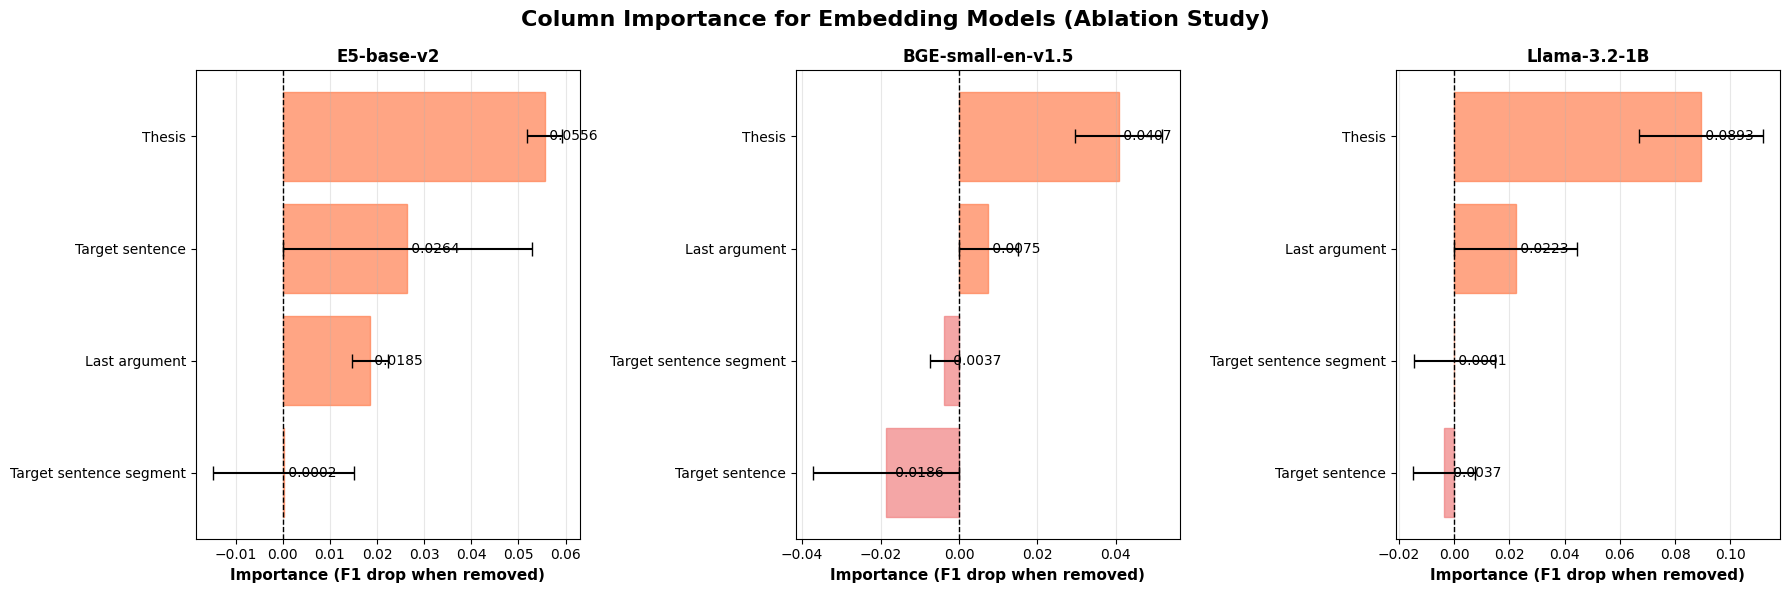


AVERAGE COLUMN IMPORTANCE ACROSS ALL EMBEDDING MODELS


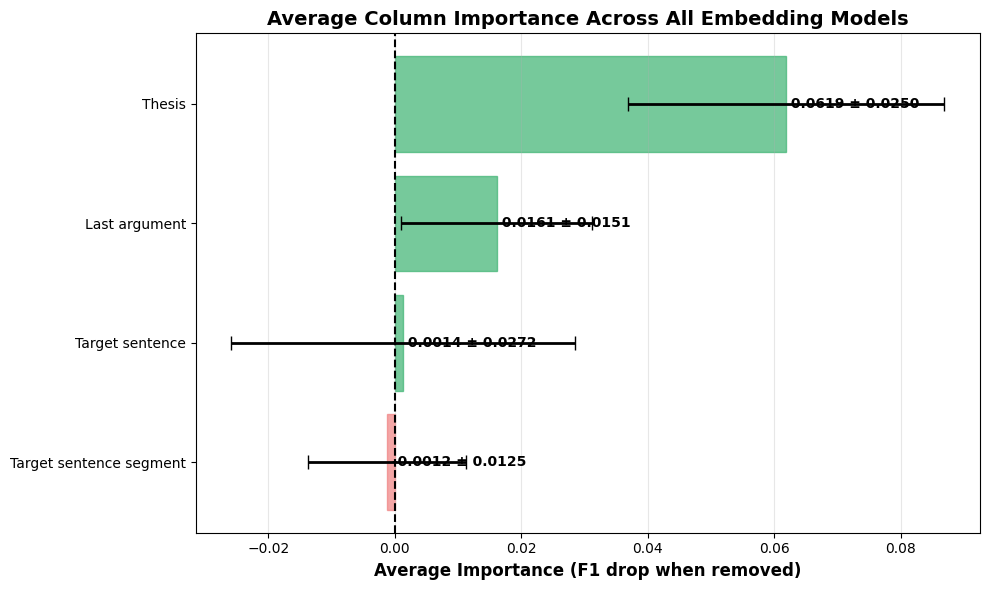


Column Importance Summary (All Embedding Models):
------------------------------------------------------------
Target sentence segment       : -0.0012 ± 0.0125
Target sentence               :  0.0014 ± 0.0272
Last argument                 :  0.0161 ± 0.0151
Thesis                        :  0.0619 ± 0.0250


In [ ]:
# Cell 22b: Column ablation analysis for embeddings (including Llama)
print("\n" + "="*80)
print("COLUMN IMPORTANCE ANALYSIS FOR EMBEDDINGS")
print("="*80)
print("\nMeasuring importance by column ablation (removing each column's embeddings):\n")

# Store column dimension info
e5_dim = X_train_e5_cols[0].shape[1]
bge_dim = X_train_bge_cols[0].shape[1]

embedding_ablation_results = {}

# Determine which embeddings to analyze
embeddings_to_analyze = ['E5-base-v2', 'BGE-small-en-v1.5']
if llama_available:
    embeddings_to_analyze.append('Llama-3.2-1B')
    llama_dim = X_train_llama_cols[0].shape[1]

for emb_name in embeddings_to_analyze:
    if emb_name == 'E5-base-v2':
        X_tr, X_v = X_train_e5, X_val_e5
        cols_list = X_train_e5_cols
        val_cols_list = X_val_e5_cols
        dim_per_col = e5_dim
    elif emb_name == 'BGE-small-en-v1.5':
        X_tr, X_v = X_train_bge, X_val_bge
        cols_list = X_train_bge_cols
        val_cols_list = X_val_bge_cols
        dim_per_col = bge_dim
    else:  # Llama
        X_tr, X_v = X_train_llama, X_val_llama
        cols_list = X_train_llama_cols
        val_cols_list = X_val_llama_cols
        dim_per_col = llama_dim

    print(f"\n{emb_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{emb_name}_{model_name}"

        # Train a fresh model for this analysis
        model_config = models[model_name]
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train
        y_v = y_val_encoded if model_name == 'XGBoost' else y_val

        # Train baseline model
        baseline_model = model_config['model']
        baseline_model.fit(X_tr, y_tr)
        baseline_pred = baseline_model.predict(X_v)
        baseline_f1 = f1_metric(y_v, baseline_pred, average='weighted')

        print(f"\n{model_name}:")
        print(f"  Baseline F1 (all columns): {baseline_f1:.4f}")

        # Test importance by removing each column's embeddings
        column_importance = {}
        for i, col in enumerate(text_columns):
            # Create ablated embeddings (all columns except current one)
            train_ablated_cols = [cols_list[j] for j in range(len(text_columns)) if j != i]
            val_ablated_cols = [val_cols_list[j] for j in range(len(text_columns)) if j != i]

            X_tr_ablated = np.hstack(train_ablated_cols)
            X_v_ablated = np.hstack(val_ablated_cols)

            # Train and predict with ablated data
            ablated_model = model_config['model']
            ablated_model.fit(X_tr_ablated, y_tr)
            ablated_pred = ablated_model.predict(X_v_ablated)
            ablated_f1 = f1_metric(y_v, ablated_pred, average='weighted')

            # Importance = drop in performance when column removed
            importance = baseline_f1 - ablated_f1
            column_importance[col] = importance

            print(f"  {col}: {importance:.4f} (F1 without: {ablated_f1:.4f})")

        embedding_ablation_results[key] = column_importance

# Visualize embedding column importance
num_embeddings = len(embeddings_to_analyze)
fig, axes = plt.subplots(1, num_embeddings, figsize=(6*num_embeddings, 6))
if num_embeddings == 1:
    axes = [axes]  # Make it iterable if only one subplot

fig.suptitle('Column Importance for Embedding Models (Ablation Study)', fontsize=16, fontweight='bold')

for idx, emb_name in enumerate(embeddings_to_analyze):
    ax = axes[idx]

    # Collect importance across models for this embedding
    importance_by_col = {col: [] for col in text_columns}
    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{emb_name}_{model_name}"
        if key in embedding_ablation_results:
            for col, imp in embedding_ablation_results[key].items():
                importance_by_col[col].append(imp)

    # Calculate mean and std
    cols = list(importance_by_col.keys())
    means = [np.mean(importance_by_col[col]) for col in cols]
    stds = [np.std(importance_by_col[col]) for col in cols]

    # Sort by importance
    sorted_indices = np.argsort(means)
    cols_sorted = [cols[i] for i in sorted_indices]
    means_sorted = [means[i] for i in sorted_indices]
    stds_sorted = [stds[i] for i in sorted_indices]

    # Plot
    bars = ax.barh(cols_sorted, means_sorted, xerr=stds_sorted,
                   color='coral', alpha=0.7, edgecolor='black', capsize=5)

    # Color coding
    for bar, val in zip(bars, means_sorted):
        if val < 0:
            bar.set_color('lightcoral')
        else:
            bar.set_color('coral')

    # Add value labels
    for i, (col, mean, std) in enumerate(zip(cols_sorted, means_sorted, stds_sorted)):
        ax.text(mean, i, f' {mean:.4f}', va='center', fontsize=10)

    ax.set_xlabel('Importance (F1 drop when removed)', fontsize=11, fontweight='bold')
    ax.set_title(f'{emb_name}', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary: Average column importance across ALL embedding models
print("\n" + "="*80)
print("AVERAGE COLUMN IMPORTANCE ACROSS ALL EMBEDDING MODELS")
print("="*80)

overall_importance_by_col = {col: [] for col in text_columns}
for key, col_imp in embedding_ablation_results.items():
    for col, imp in col_imp.items():
        overall_importance_by_col[col].append(imp)

overall_means = {col: np.mean(vals) for col, vals in overall_importance_by_col.items()}
overall_stds = {col: np.std(vals) for col, vals in overall_importance_by_col.items()}

# Sort by importance
sorted_cols = sorted(overall_means.keys(), key=lambda x: overall_means[x])
sorted_means = [overall_means[col] for col in sorted_cols]
sorted_stds = [overall_stds[col] for col in sorted_cols]

# Create overall summary plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(sorted_cols, sorted_means, xerr=sorted_stds,
               color='mediumseagreen', alpha=0.7, edgecolor='black',
               capsize=5, error_kw={'linewidth': 2})

# Color bars
for bar, val in zip(bars, sorted_means):
    if val < 0:
        bar.set_color('lightcoral')
    else:
        bar.set_color('mediumseagreen')

# Add value labels
for i, (col, mean, std) in enumerate(zip(sorted_cols, sorted_means, sorted_stds)):
    ax.text(mean, i, f' {mean:.4f} ± {std:.4f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Average Importance (F1 drop when removed)', fontsize=12, fontweight='bold')
ax.set_title('Average Column Importance Across All Embedding Models', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nColumn Importance Summary (All Embedding Models):")
print("-" * 60)
for col in sorted_cols:
    print(f"{col:30s}: {overall_means[col]:7.4f} ± {overall_stds[col]:.4f}")

In [ ]:
# Cell 28: Identify and save the overall best model
import pickle
import json
from datetime import datetime

# Combine all results (traditional vectorizers + embeddings)
all_results = {**embedding_results}

# Find the best model based on test F1 score
best_config = None
best_f1 = 0
best_key = None
best_type = None  # 'traditional' or 'embedding'

print("="*80)
print("EVALUATING ALL MODELS")
print("="*80)

for key, res in all_results.items():
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])
    test_f1 = f1_score(y_t, y_test_pred, average='weighted')
    test_acc = accuracy_score(y_t, y_test_pred)

    print(f"{key:50s} - Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_key = key
        best_config = res
        # Determine if it's traditional or embedding-based
        best_type = 'embedding' if 'embedding_name' in res else 'traditional'

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest configuration: {best_key}")
print(f"Model type: {best_type}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Best hyperparameters: {best_config['best_params']}")

# Calculate test accuracy for best model
y_t = y_test_encoded if best_config['is_xgboost'] else y_test
y_test_pred_best = best_config['best_model'].predict(best_config['X_test'])
test_accuracy = accuracy_score(y_t, y_test_pred_best)

# Prepare the complete pipeline components based on model type
# Embedding-based model
embedding_name = best_config['embedding_name']
model_package = {
        'model': best_config['best_model'],
        'label_encoder': label_encoder,
        'text_columns': text_columns,
        'is_xgboost': best_config['is_xgboost'],
        'config_name': best_key,
        'model_type': 'embedding',
        'embedding_name': embedding_name,
        'best_params': best_config['best_params'],
        'performance': {
            'test_f1': best_f1,
            'test_accuracy': test_accuracy,
            'cv_f1_mean': best_config['cv_scores']['test_f1_weighted'].mean(),
            'cv_f1_std': best_config['cv_scores']['test_f1_weighted'].std(),
            'cv_accuracy_mean': best_config['cv_scores']['test_accuracy'].mean(),
            'cv_accuracy_std': best_config['cv_scores']['test_accuracy'].std()
        },
        'preprocessing_info': {
            'preprocessing': 'none',
            'embedding_model': embedding_name,
            'per_column_embedding': True
        },
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

# Save the model package
model_filename = f'best_overall_model_{best_key.replace(" ", "_").replace("/", "-")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved to: {model_filename}")
print(f"Package includes: model, {'transformer, ' if best_type == 'traditional' else ''}label encoder, and metadata")

# Save metadata separately as JSON for easy inspection
metadata = {
    'config_name': best_key,
    'model_type': best_type,
    'best_params': best_config['best_params'],
    'performance': model_package['performance'],
    'preprocessing_info': model_package['preprocessing_info'],
    'text_columns': text_columns,
    'timestamp': model_package['timestamp']
}

metadata_filename = f'best_overall_model_{best_key.replace(" ", "_").replace("/", "-")}_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to: {metadata_filename}")

EVALUATING ALL MODELS
E5-base-v2_Logistic Regression                     - Test F1: 0.8296, Test Acc: 0.8296
E5-base-v2_Decision Tree                           - Test F1: 0.7918, Test Acc: 0.7926
E5-base-v2_XGBoost                                 - Test F1: 0.8666, Test Acc: 0.8667
BGE-small-en-v1.5_Logistic Regression              - Test F1: 0.8364, Test Acc: 0.8370
BGE-small-en-v1.5_Decision Tree                    - Test F1: 0.7548, Test Acc: 0.7556
BGE-small-en-v1.5_XGBoost                          - Test F1: 0.8518, Test Acc: 0.8519
Llama_Logistic Regression                          - Test F1: 0.9037, Test Acc: 0.9037
Llama_Decision Tree                                - Test F1: 0.8222, Test Acc: 0.8222
Llama_XGBoost                                      - Test F1: 0.8812, Test Acc: 0.8815

BEST MODEL SELECTION

Best configuration: Llama_Logistic Regression
Model type: embedding
Test F1 Score: 0.9037
Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Model saved 

In [ ]:
def create_embedding_predictor(model_package):
    """
    Create a prediction function for embedding-based models.
    """
    import pandas as pd
    import numpy as np
    import torch
    from sentence_transformers import SentenceTransformer
    from transformers import AutoTokenizer, AutoModel

    embedding_name = model_package['embedding_name']

    # Determine embedding model and configuration
    if 'E5' in embedding_name or 'e5' in embedding_name:
        emb_model = SentenceTransformer('intfloat/e5-base-v2')
        use_llama = False
        prefix = 'query: '
    elif 'BGE' in embedding_name or 'bge' in embedding_name:
        emb_model = SentenceTransformer('BAAI/bge-small-en-v1.5')
        use_llama = False
        prefix = 'Represent this sentence for classification: '
    elif 'Llama' in embedding_name or 'llama' in embedding_name:
        # Load Llama model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
        emb_model = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        emb_model = emb_model.to(device)
        emb_model.eval()
        use_llama = True
        prefix = ''
    else:
        raise ValueError(f"Unknown embedding model: {embedding_name}")

    def get_llama_embeddings(texts, batch_size=8):
        """Generate Llama embeddings with mean pooling"""
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True,
                               max_length=512, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}

            with torch.no_grad():
                outputs = emb_model(**encoded)
                attention_mask = encoded['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_embeddings)

        return np.vstack(embeddings)

    def predict(data):
        """Predict labels for new data"""
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()

        # Generate embeddings for each column
        embeddings_list = []
        for col in model_package['text_columns']:
            texts = df[col].fillna('').tolist()

            if use_llama:
                col_embeddings = get_llama_embeddings(texts)
            else:
                texts_with_prefix = [prefix + text for text in texts]
                col_embeddings = emb_model.encode(texts_with_prefix, show_progress_bar=False, batch_size=32)

            embeddings_list.append(col_embeddings)

        # Concatenate all column embeddings
        X_transformed = np.hstack(embeddings_list)

        # Predict
        predictions_encoded = model_package['model'].predict(X_transformed)

        # Decode if XGBoost
        if model_package['is_xgboost']:
            predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded

        # Get probabilities if available
        probabilities = None
        if hasattr(model_package['model'], 'predict_proba'):
            probabilities = model_package['model'].predict_proba(X_transformed)

        return predictions, probabilities

    return predict

predictor = create_embedding_predictor(model_package)

# Test the predictor with a sample
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)

# Use raw test data for realistic test
test_sample = test_df[text_columns].iloc[0:1].copy()

print("\nTest sample shape:", test_sample.shape)

predictions, probabilities = predictor(test_sample)

print(f"\nPrediction: {predictions[0]}")
print(f"True label: {test_df['Dim1_label'].iloc[0]}")
if probabilities is not None:
    print(f"Probabilities: {probabilities[0]}")

print("\n✓ Model package is working correctly!")


TESTING SAVED MODEL

Test sample shape: (1, 4)

Prediction: L
True label: L
Probabilities: [8.89339421e-04 9.99110661e-01]

✓ Model package is working correctly!


In [ ]:
# Cell 30: REPLACE - Save standalone predictor modules with full Llama support
traditional_predictor_code = '''"""
Standalone predictor for traditional vectorizer-based models.

Usage:
------
import pickle
from traditional_predictor import load_model_and_predict

with open('best_overall_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import spacy
import pandas as pd

def preprocess_text(text, nlp):
    """Tokenize, lowercase, and lemmatize text"""
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)

def load_model_and_predict(model_package, data):
    """Predict labels using traditional vectorizer model"""
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        raise RuntimeError("Please install spacy model: python -m spacy download en_core_web_sm")

    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
        df[col] = df[col].apply(lambda x: preprocess_text(x, nlp))

    X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])
    predictions_encoded = model_package['model'].predict(X_transformed)

    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''

embedding_predictor_code = '''"""
Standalone predictor for embedding-based models.
Supports E5, BGE, and Llama embeddings.

Requirements:
------------
pip install sentence-transformers transformers torch

Usage:
------
import pickle
from embedding_predictor import load_model_and_predict

with open('best_overall_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

def get_llama_embeddings(texts, tokenizer, model, device, batch_size=8):
    """Generate Llama embeddings with mean pooling"""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True,
                           max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def load_model_and_predict(model_package, data):
    """Predict labels using embedding-based model"""
    embedding_name = model_package['embedding_name']

    # Load appropriate embedding model
    if 'E5' in embedding_name or 'e5' in embedding_name:
        emb_model = SentenceTransformer('intfloat/e5-base-v2')
        use_llama = False
        prefix = 'query: '

    elif 'BGE' in embedding_name or 'bge' in embedding_name:
        emb_model = SentenceTransformer('BAAI/bge-small-en-v1.5')
        use_llama = False
        prefix = 'Represent this sentence for classification: '

    elif 'Llama' in embedding_name or 'llama' in embedding_name:
        print("Loading Llama model (this may take a moment)...")
        tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
        emb_model = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        emb_model = emb_model.to(device)
        emb_model.eval()
        use_llama = True
        print(f"Llama model loaded on {device}")

    else:
        raise ValueError(f"Unsupported embedding model: {embedding_name}")

    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    # Generate embeddings for each column
    embeddings_list = []
    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

        texts = df[col].fillna('').tolist()

        if use_llama:
            col_embeddings = get_llama_embeddings(texts, tokenizer, emb_model, device)
        else:
            texts_with_prefix = [prefix + text for text in texts]
            col_embeddings = emb_model.encode(texts_with_prefix, show_progress_bar=False, batch_size=32)

        embeddings_list.append(col_embeddings)

    # Concatenate all column embeddings
    X_transformed = np.hstack(embeddings_list)

    # Predict
    predictions_encoded = model_package['model'].predict(X_transformed)

    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''
predictor_filename = 'embedding_predictor.py'
with open(predictor_filename, 'w') as f:
    f.write(embedding_predictor_code)

print("\n" + "="*80)
print("PREDICTOR MODULE SAVED")
print("="*80)
print(f"\nSaved files:")
print(f"  1. {model_filename} - Complete model package")
print(f"  2. {metadata_filename} - Model metadata (JSON)")
print(f"  3. {predictor_filename} - Standalone prediction module")
print(f"\nModel Type: {best_type.upper()}")
if best_type == 'embedding':
    print(f"Embedding Model: {model_package['embedding_name']}")
    if 'Llama' in model_package['embedding_name']:
        print(f"\n⚠️  Note: Llama requires transformers and torch packages")
        print(f"   Installation: pip install transformers torch")
print(f"\nTo use in a new pipeline:")
print(f"  import pickle")
print(f"  from {predictor_filename[:-3]} import load_model_and_predict")
print(f"  ")
print(f"  with open('{model_filename}', 'rb') as f:")
print(f"      model_package = pickle.load(f)")
print(f"  ")
print(f"  predictions, probs = load_model_and_predict(model_package, your_data)")


PREDICTOR MODULE SAVED

Saved files:
  1. best_overall_model_Llama_Logistic_Regression.pkl - Complete model package
  2. best_overall_model_Llama_Logistic_Regression_metadata.json - Model metadata (JSON)
  3. embedding_predictor.py - Standalone prediction module

Model Type: EMBEDDING
Embedding Model: Llama

⚠️  Note: Llama requires transformers and torch packages
   Installation: pip install transformers torch

To use in a new pipeline:
  import pickle
  from embedding_predictor import load_model_and_predict
  
  with open('best_overall_model_Llama_Logistic_Regression.pkl', 'rb') as f:
      model_package = pickle.load(f)
  
  predictions, probs = load_model_and_predict(model_package, your_data)
